In [ ]:
#conncet to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# switch to working path
import os
repo_name = "hurricane-harm-herald"
target_dir = "/content/drive/MyDrive/ai4er/python/hurricane"
os.chdir(target_dir)
print(os.getcwd())

/content/drive/MyDrive/ai4er/python/hurricane


In [ ]:
%cd /content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks

/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks


In [ ]:
#install required packs
!pip install rasterio 
!pip install richdem
!pip install geopandas
!pip install vptree geographiclib
!pip install cartopy
!pip install pandas==1.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 48.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 KB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for richdem: filename=richdem-0.3.4-cp38-cp38-linux_x86_64.whl size=7997076 sha256=8eadf7e0160a60925f51db56cc27792d9bab7685b196d2f70234197d380515bc
  Stored in directory: /root/.cache/pip/wheels/9f/9c/61/8da642da1b65cbf887fa5d335778dfcefe22fba629e6b055d4
Successfully built richdem
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# import packages
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import richdem as rd
from scipy.interpolate import interp2d
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import pickle
import vptree
from geographiclib.geodesic import Geodesic
import cartopy.crs as ccrs
import math
import urllib.request
import requests
import zipfile
import glob
from affine import Affine
import shapefile 
import cartopy.feature as cfeature

In [ ]:
temp_path= '/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/lnglat_pre_pol_post_damage.pkl'


In [ ]:
#load the data of the locations (lon, lat) of buildings
building_locs_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/df_points_posthurr_old.pkl' 
with open(building_locs_path, 'rb') as f:
    building_locs = pickle.load(f)

building_locs

,geometry,damage_class,disaster_name,capture_date
0,POINT (-77.92443 34.78850),2,hurricane-florence,2018-09-20 16:04:41+00:00
1,POINT (-77.92459 34.78817),1,hurricane-florence,2018-09-20 16:04:41+00:00
2,POINT (-85.61007 30.20004),0,hurricane-michael,2018-10-13 16:48:15+00:00
3,POINT (-85.61057 30.20001),0,hurricane-michael,2018-10-13 16:48:15+00:00
4,POINT (-85.61055 30.20060),1,hurricane-michael,2018-10-13 16:48:15+00:00
...,...,...,...,...
23049,POINT (-77.91797 34.64623),0,hurricane-florence,2018-09-20 16:04:41+00:00
23050,POINT (-77.91773 34.64628),0,hurricane-florence,2018-09-20 16:04:41+00:00
23051,POINT (-77.91765 34.64650),0,hurricane-florence,2018-09-20 16:04:41+00:00
23052,POINT (-77.91835 34.64612),0,hurricane-florence,2018-09-20 16:04:41+00:00


In [ ]:
building_locs=pd.DataFrame({'lat':building_locs['geometry'].y,'lon':building_locs['geometry'].x })
#building_locs['lat'],building_locs['lon']=building_locs['geometry'].y,building_locs['geometry'].x 

#divide the building locations into groups that cover 1 degree latitude and longitude
lon_bins = pd.cut(building_locs['lon'], bins=range(-180, 181, 1))
lat_bins = pd.cut(building_locs['lat'], bins=range(-90, 91, 1))

building_groups = building_locs.groupby([lon_bins, lat_bins])

In [ ]:
# check the data
building_locs

,lat,lon
0,34.788502,-77.924432
1,34.788174,-77.924586
2,30.200042,-85.610074
3,30.200012,-85.610569
4,30.200601,-85.610547
...,...,...
23049,34.646233,-77.917967
23050,34.646278,-77.917726
23051,34.646497,-77.917652
23052,34.646123,-77.918351


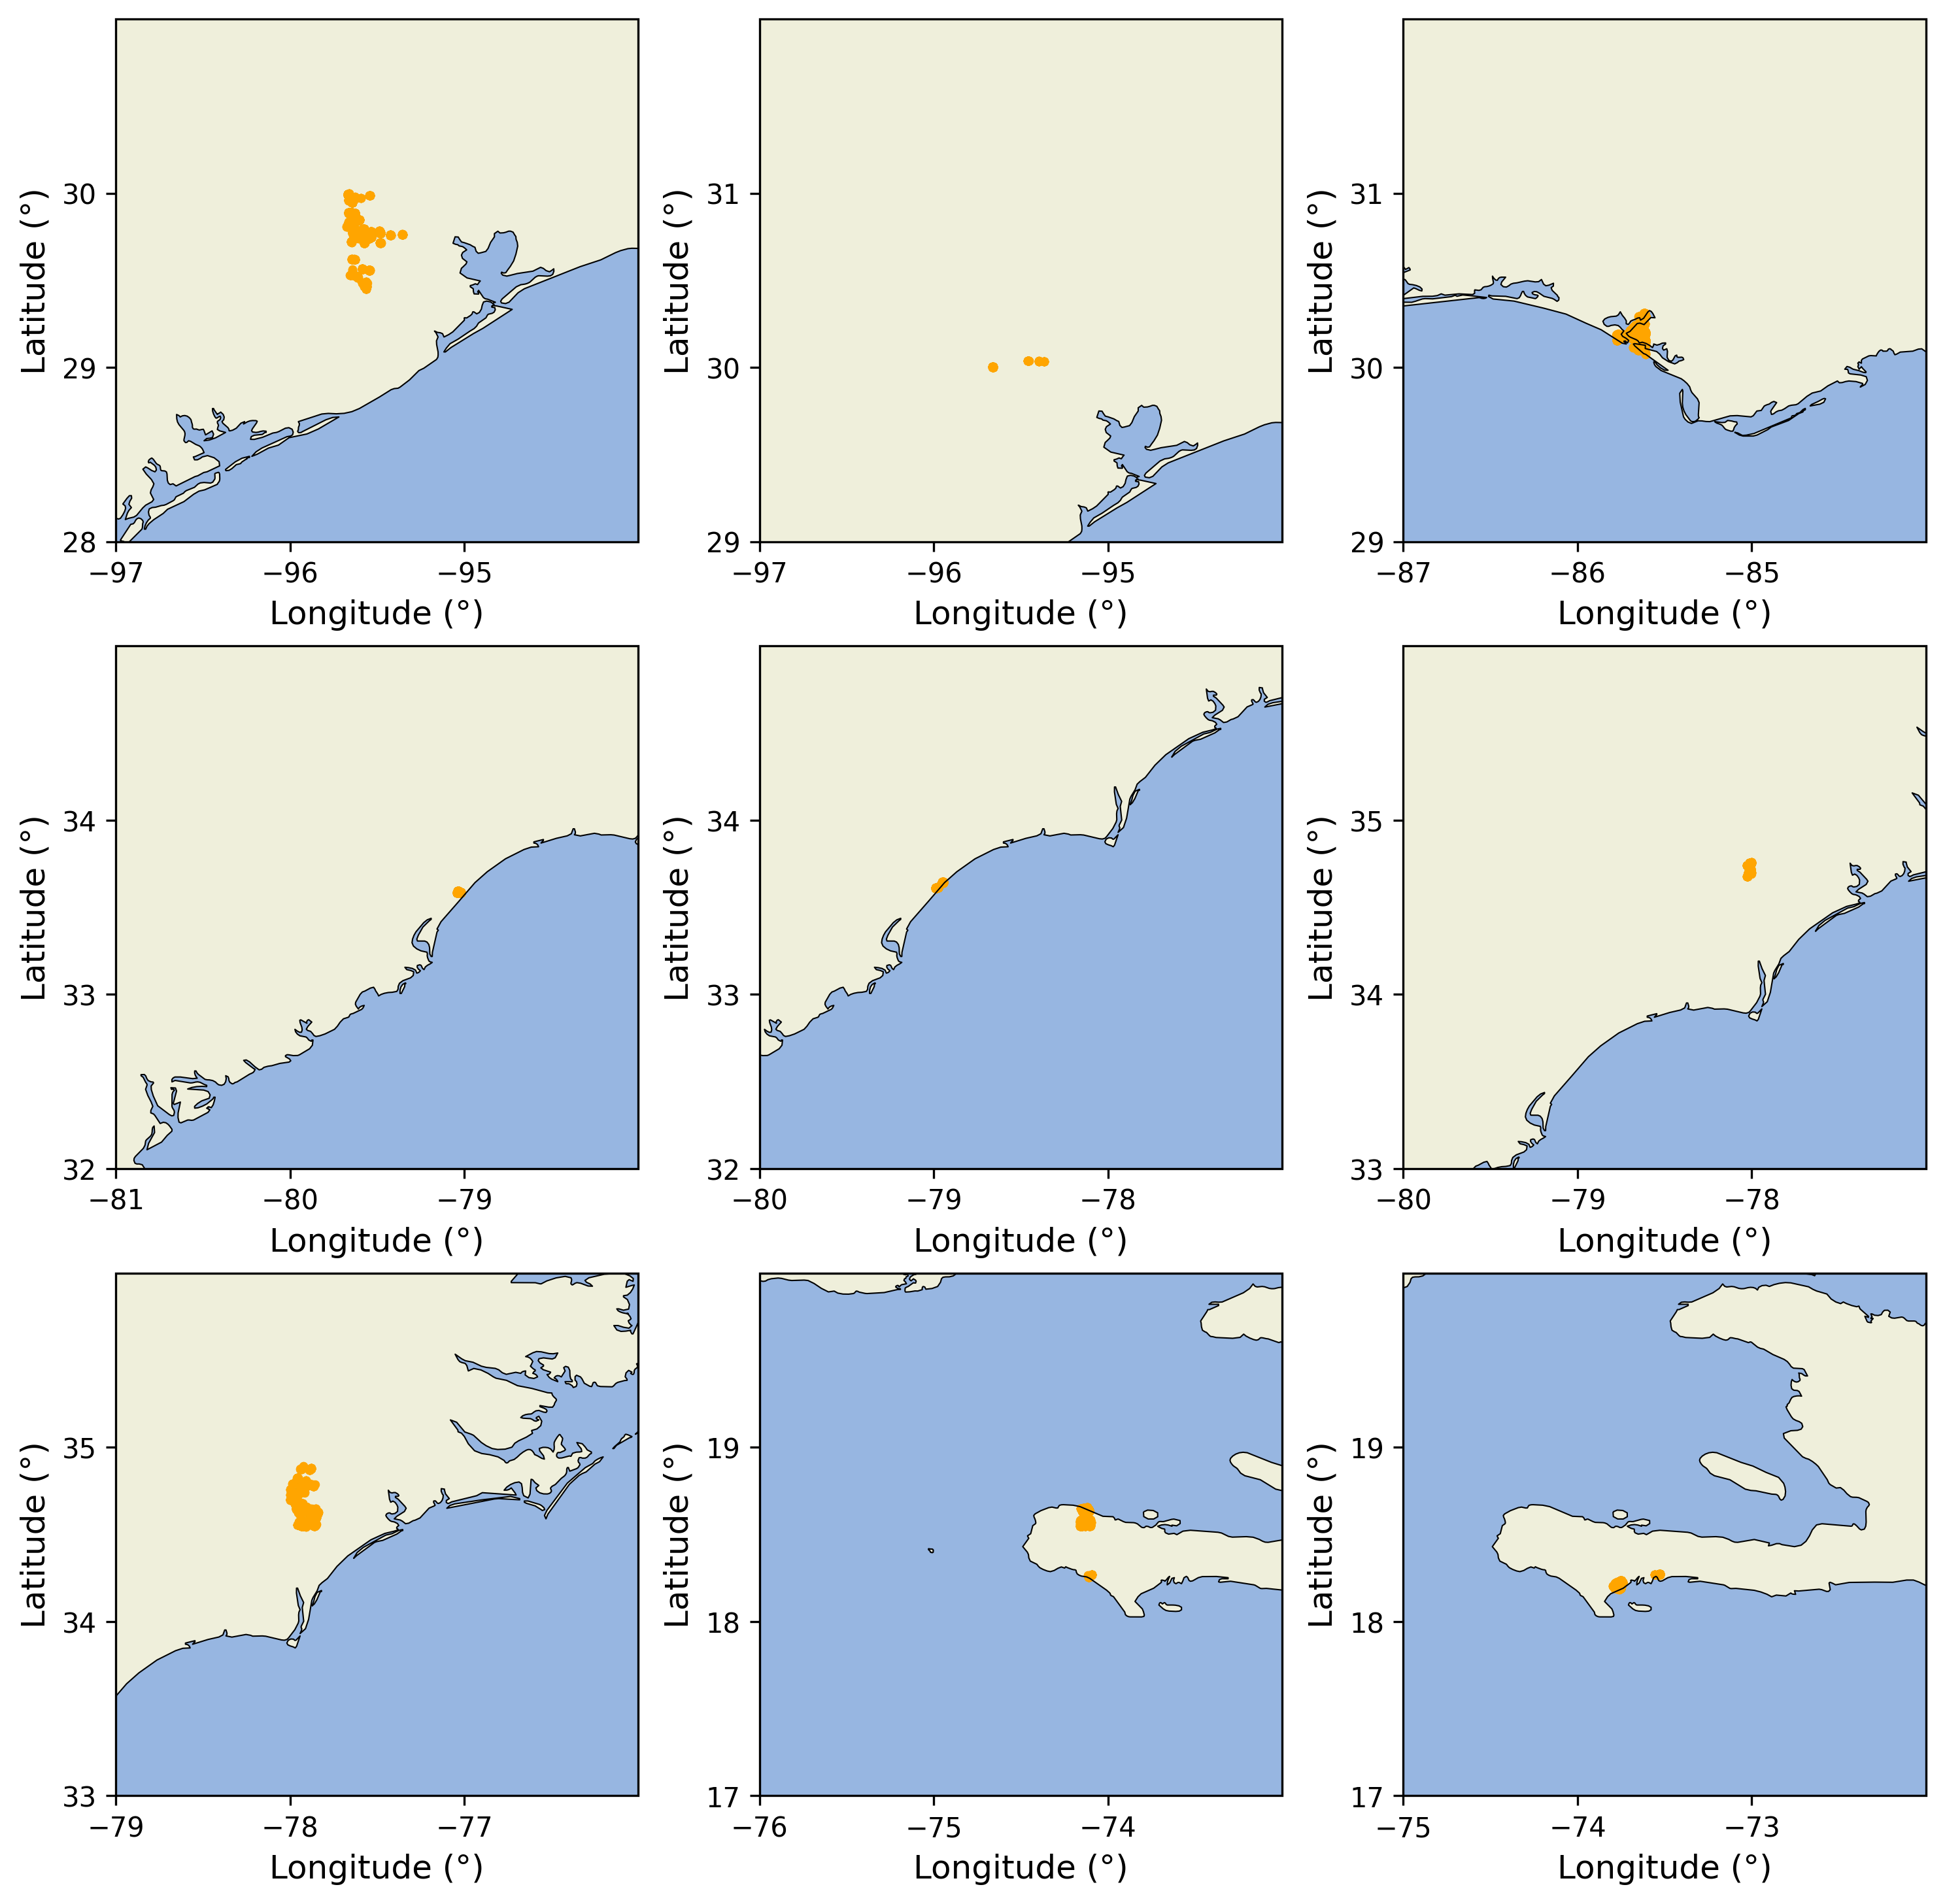

In [ ]:
#plot the building locations for verification
n_groups = len(building_groups) #group number
n_cols=3                        #column number
n_rows = math.ceil(n_groups / n_cols)   # raw number
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (group_name, group_data) in enumerate(building_groups):
    west=int(np.floor(group_data['lon'].min()))
    east=int(np.ceil(group_data['lon'].max()))
    south=int(np.floor(group_data['lat'].min()))
    north=int(np.ceil(group_data['lat'].max()))
    dis_threshold=1
    # plot the buildings and the coastline data that been choped
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    ax.set_xlim(west-dis_threshold, east+dis_threshold)
    ax.set_ylim(south-dis_threshold, north+dis_threshold)

    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    #plot the locations of buildings
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree(),c='orange')
    # Set x-label and y-label
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks
    xticks = np.arange(west-dis_threshold, east+dis_threshold, dis_threshold)
    yticks = np.arange(south-dis_threshold, north+dis_threshold, dis_threshold)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1
plt.show()

In [ ]:
# This cell check whether coastline data has been downloaded
# You can download coastline data from Nature Earth (https://www.naturalearthdata.com/downloads/10m-physical-vectors/),
# and store the .zip coastline data to 'zip_path' (please change it according to your setting)

url='https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_coastline.zip'
zip_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline.zip'
shp_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline/ne_10m_coastline.shp'
coast_extracted_floder='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline/'
pkl_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline/ne_10m_coastline.pkl'

# check whether the .shp or .zip coastline data exist
if os.path.isfile(shp_path):
  print('.shp coastline file found')
else:
  if os.path.isfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(coast_extracted_floder) # the coastline data is in 10m resolution
  else:
    print('.zip coastline file not found, please download it from ',url,' manually') 


.shp coastline file found


In [ ]:
# Load the .shp coastline data
# Convert the .shp coast line data into points and store in a dataframe
shapefile = gpd.read_file(shp_path) # Read the shapefile
coast_points = pd.DataFrame(columns=['coast_lon', 'coast_lat'])  # Initialize the coast_points DataFrame
temp_array = []  # Initialize the temp_array as a list
for i, row in shapefile.iterrows():
    if row['geometry'].geom_type == 'LineString':
        for point in row['geometry'].coords:
            x, y = point
            p = [x, y]  # Create a list with two elements
            temp_array.append(p)  # Append the point to the list
        temp_df = pd.DataFrame(temp_array, columns=['coast_lon', 'coast_lat'])  # Create a DataFrame from the temp_array
        coast_points = pd.concat([coast_points, temp_df], ignore_index=True)  # Append the temp_df to the coast_points DataFrame
        temp_array = []  # Reset the temp_array to an empty list

coast_points     

,coast_lon,coast_lat
0,59.916026,-67.400486
1,59.678559,-67.394138
2,59.657481,-67.397231
3,59.646251,-67.406183
4,59.648123,-67.415948
...,...,...
410952,-0.004789,-0.00439
410953,-0.004789,0.004817
410954,0.004328,0.004817
410955,0.004328,-0.00439


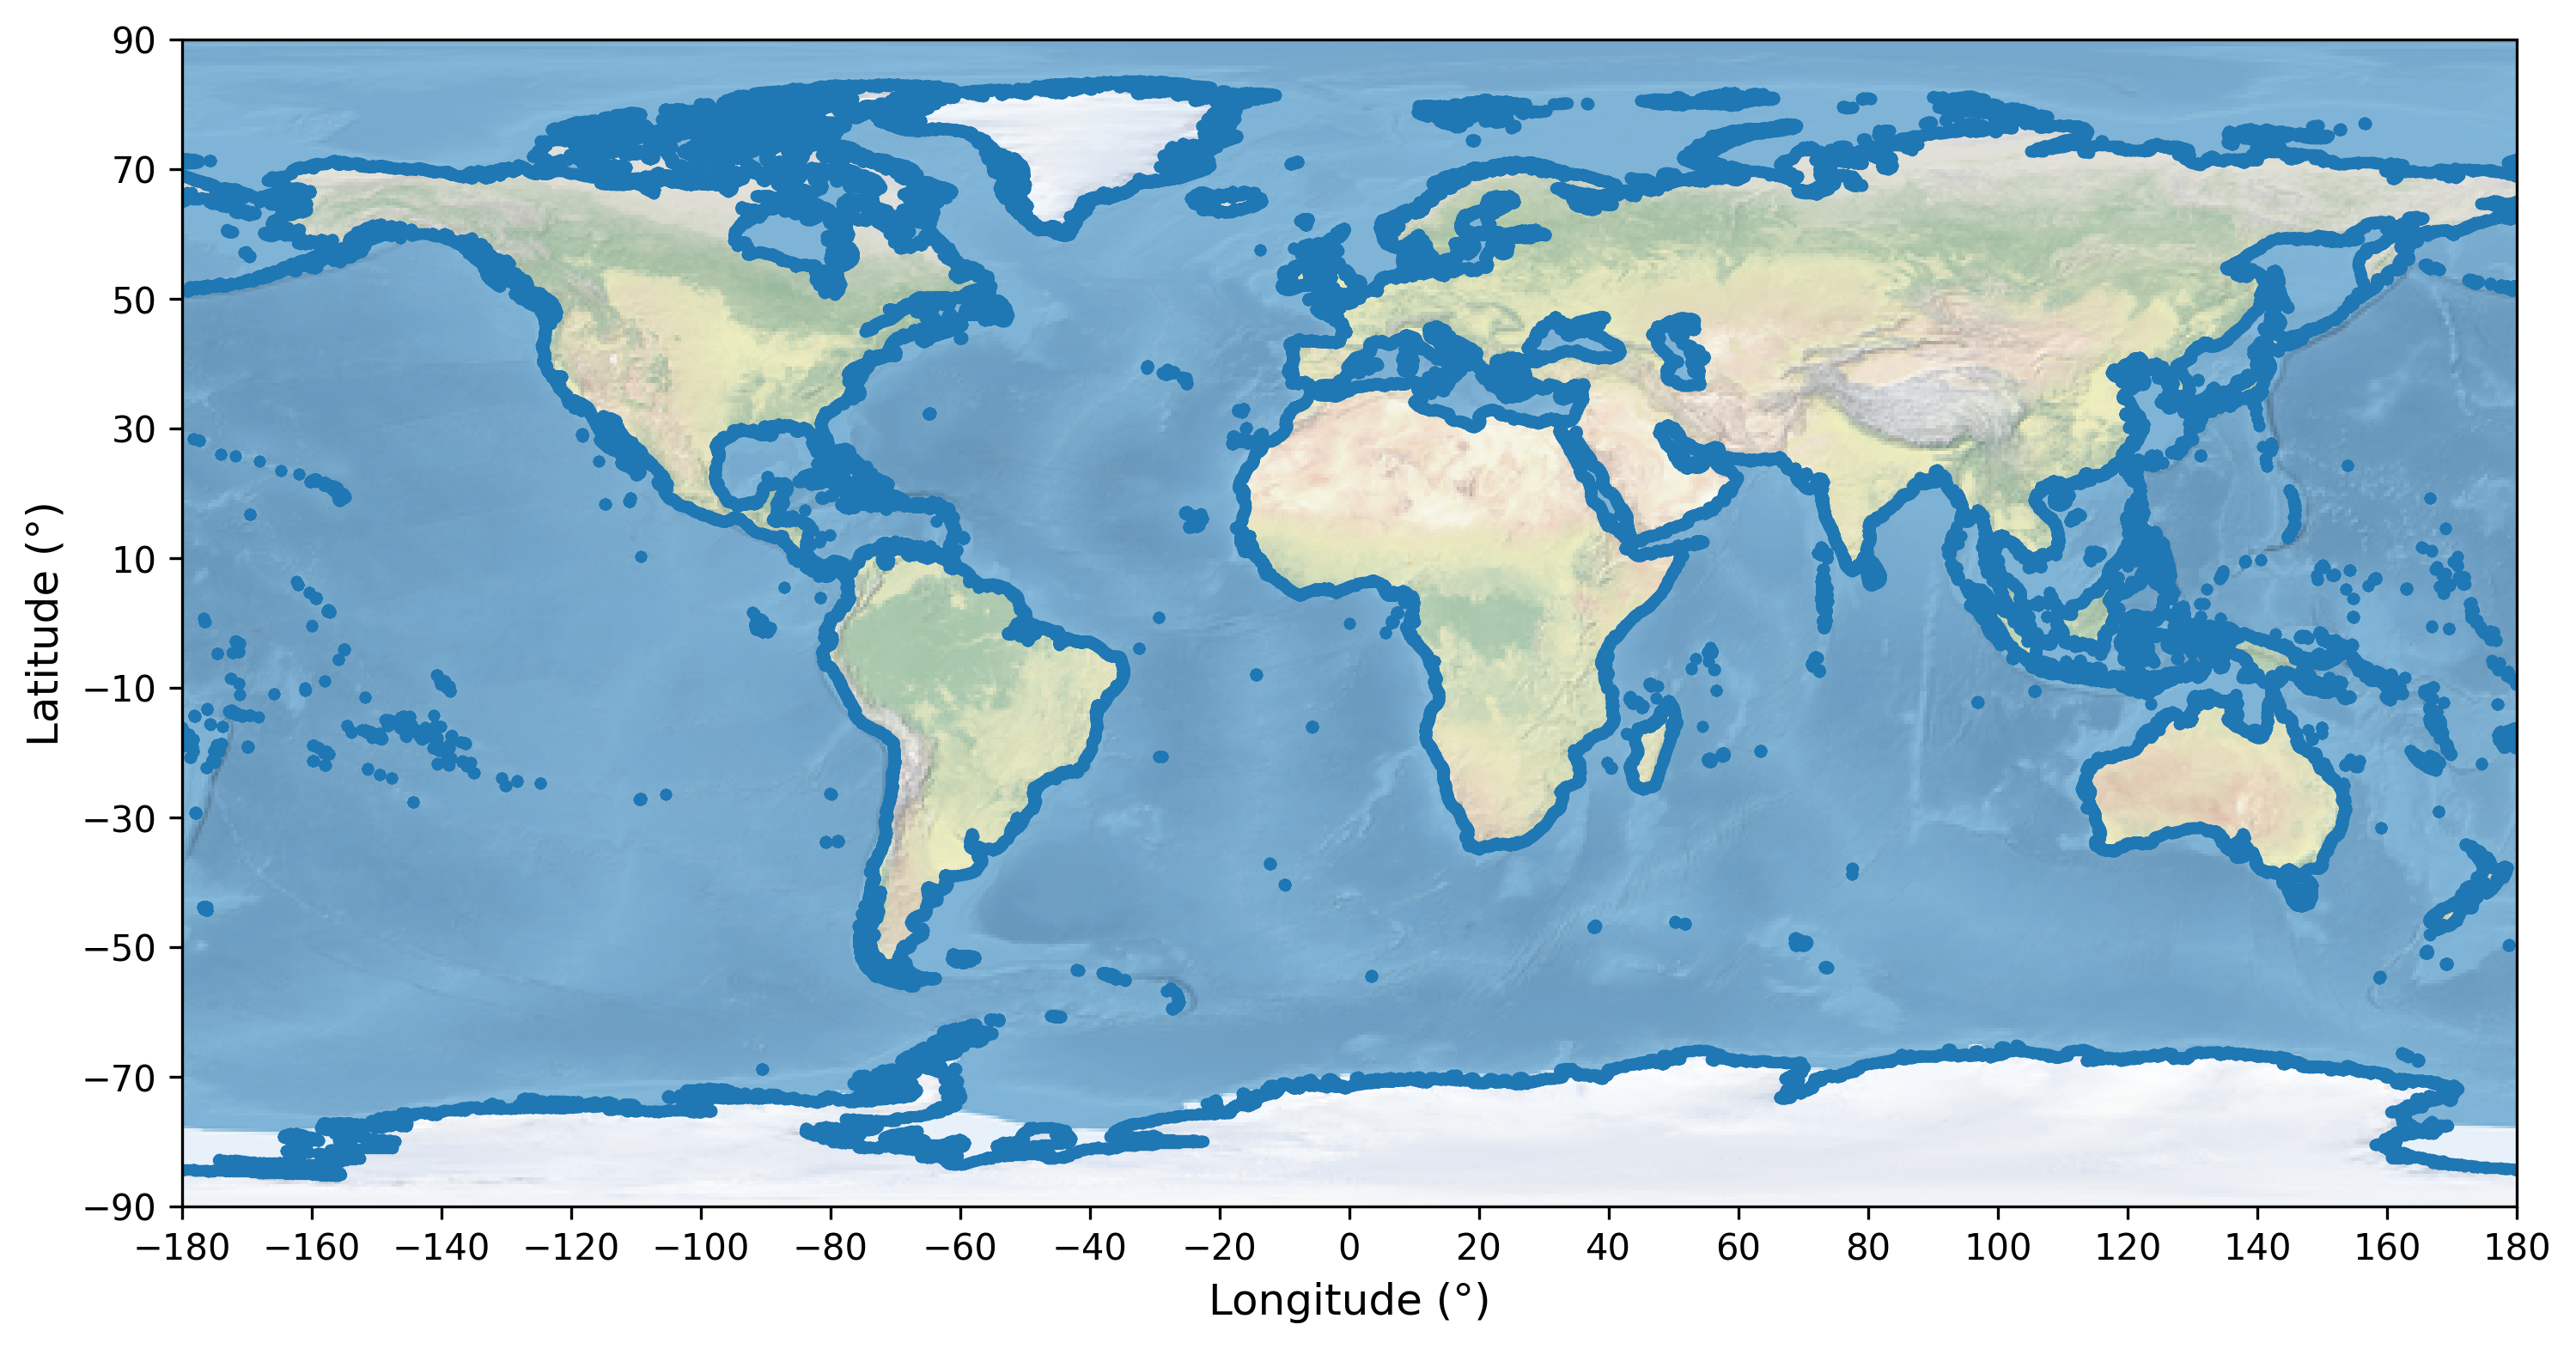

In [ ]:
# Plot the coastline data for verification

fig = plt.figure(figsize=(12, 6),dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Add a global map background
ax.stock_img()
# Plot the coast points
ax.scatter(coast_points['coast_lon'], coast_points['coast_lat'], s=5, transform=ccrs.PlateCarree())
# Set x-label and y-label
ax.set_xlabel('Longitude (°)', fontsize=12)
ax.set_ylabel('Latitude (°)', fontsize=12)
# Set x-ticks and y-ticks
xticks = np.arange(-180, 190, 20)
yticks = np.arange(-90, 100, 20)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

plt.show()


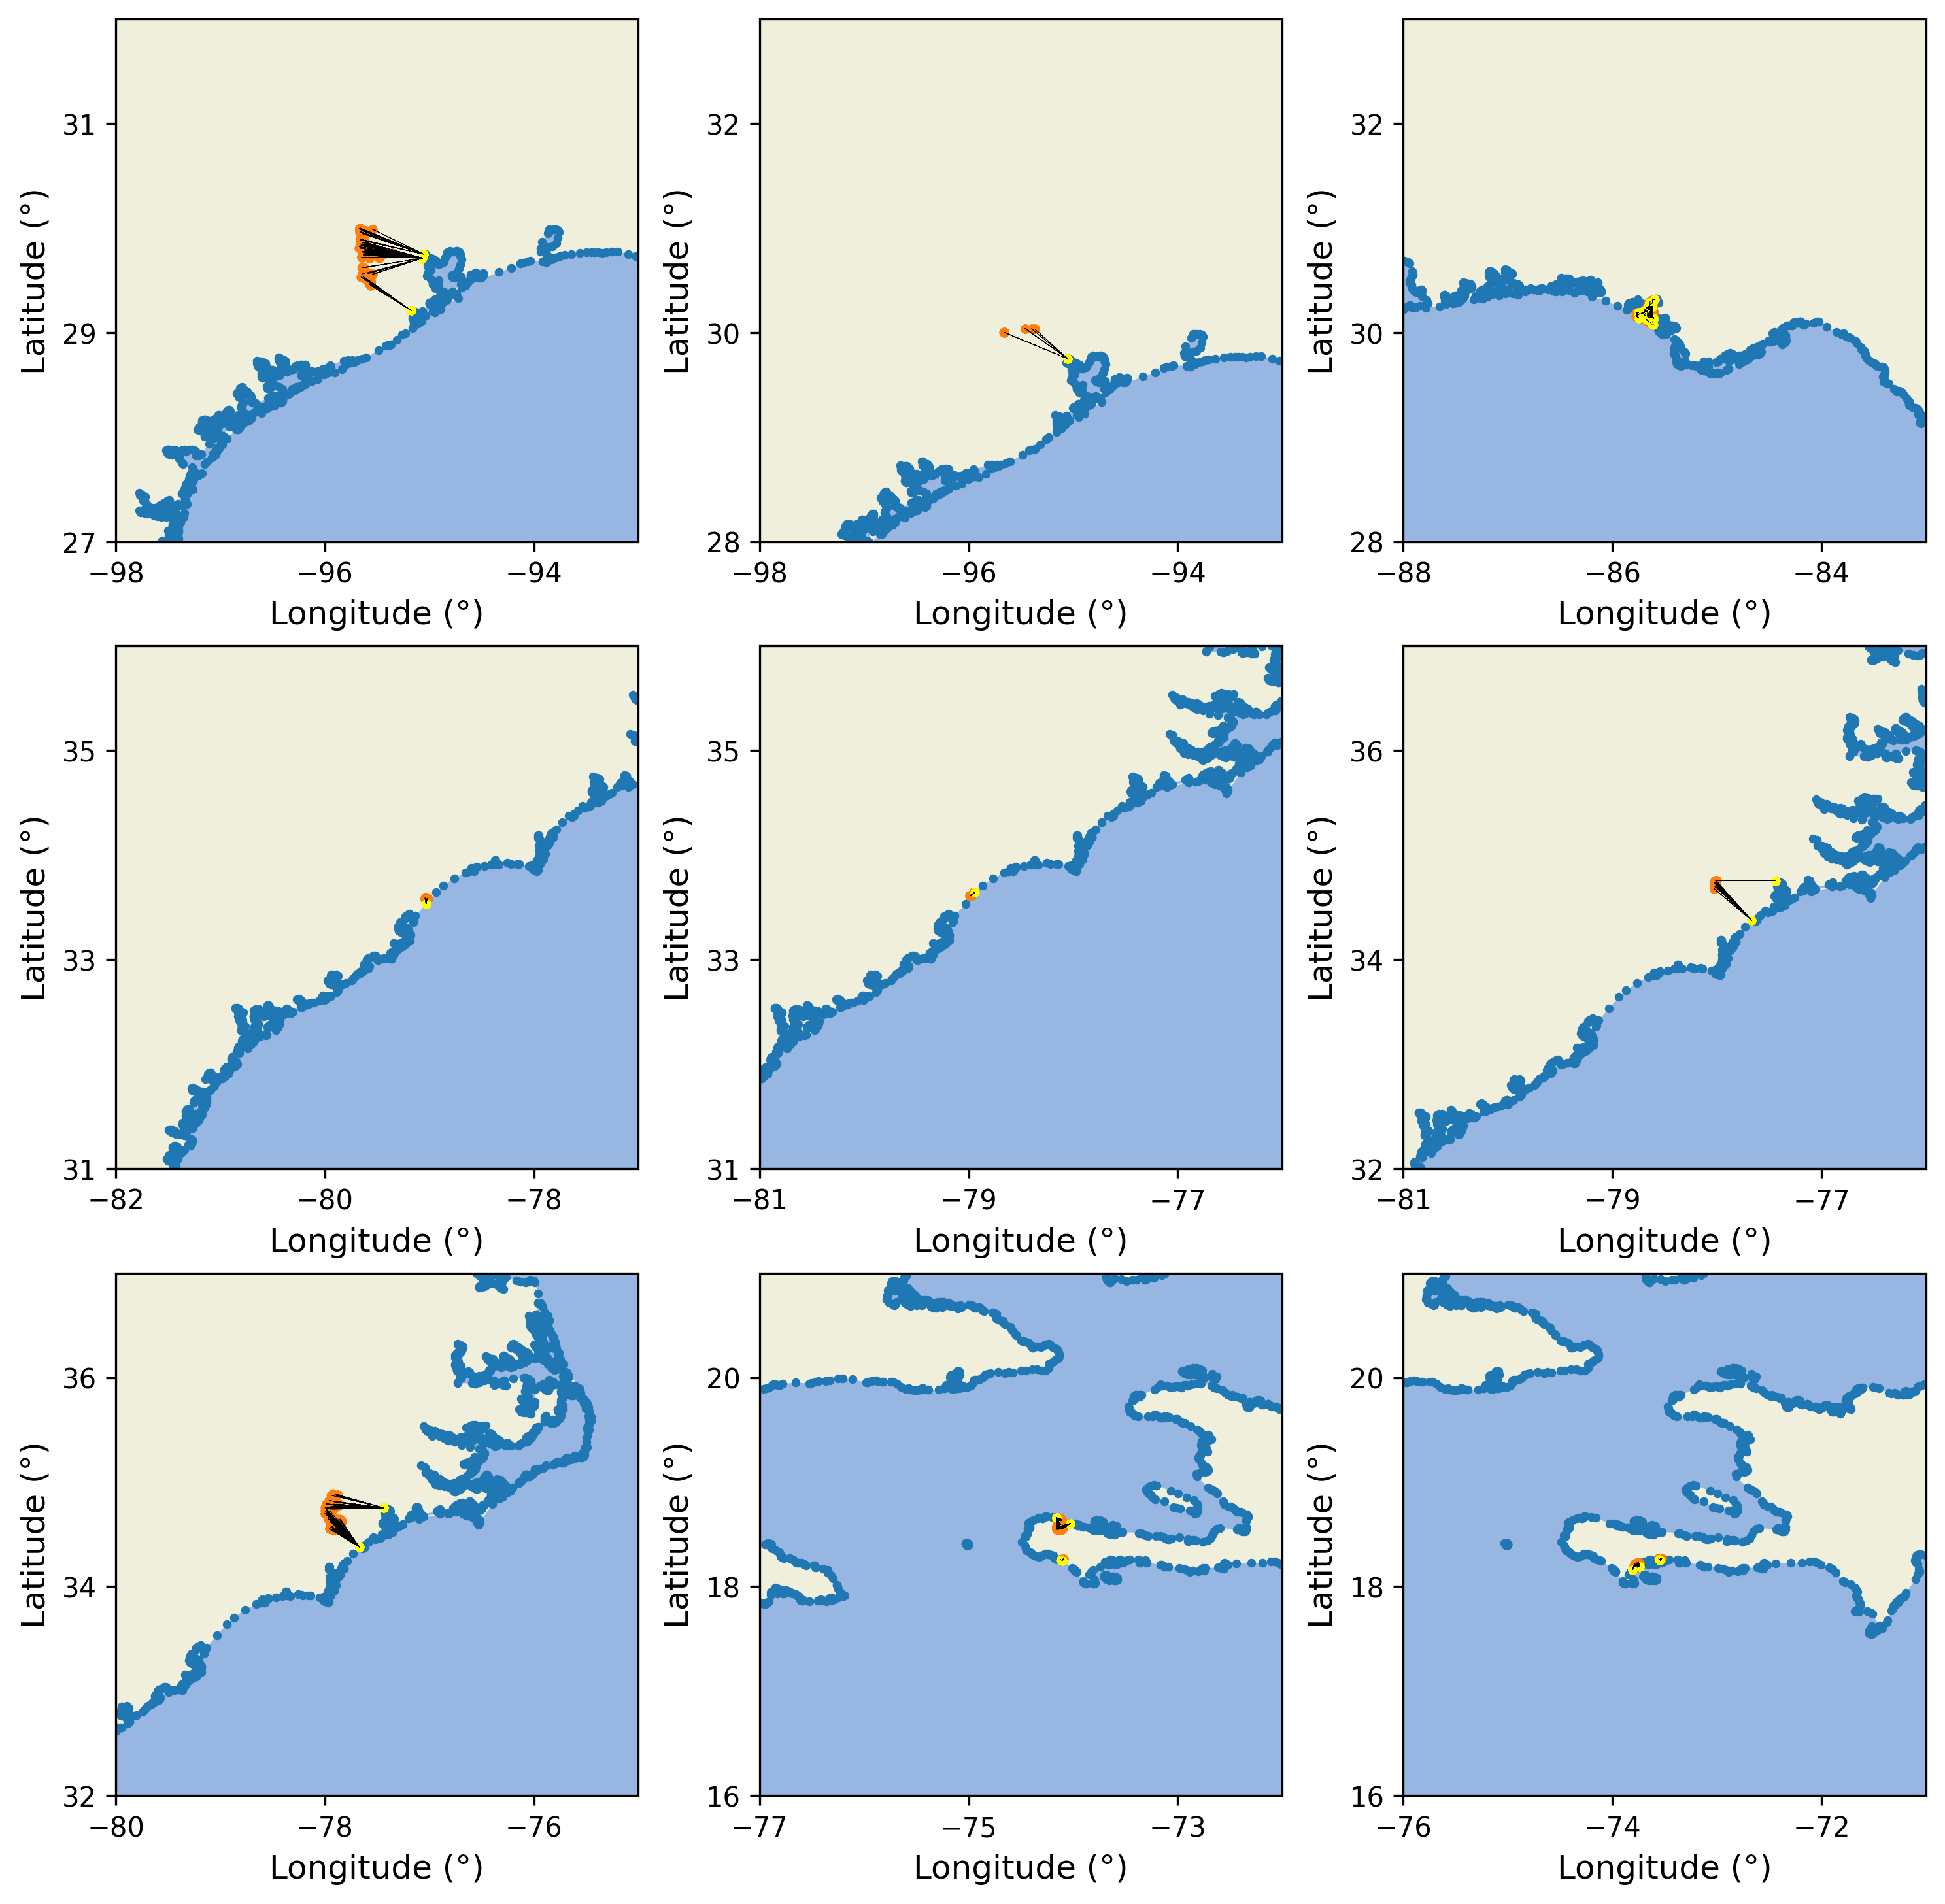

In [ ]:
# Find the closest point on the coastline to the building and return the distance
# NOTE! this cell is quite time consuming to run (dependding on the size of building location data and the coastline data)

# define the function that calculate Geodesic distance between two points
def geoddist(p1, p2):
  return Geodesic.WGS84.Inverse(p1[1], p1[0], p2[1], p2[0])['s12']

n_groups = len(building_groups) #
n_cols=3
n_rows = math.ceil(n_groups / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (group_name, group_data) in enumerate(building_groups):
    west=int(np.floor(group_data['lon'].min()))
    east=int(np.ceil(group_data['lon'].max()))
    south=int(np.floor(group_data['lat'].min()))
    north=int(np.ceil(group_data['lat'].max()))

    dis_threshold=2 # assuming the building is not more than dis_threshold latitude and longitude away from the coast, please change it according to your case

    # chop the coastline data
    mask = (coast_points['coast_lon'] >= west-dis_threshold) & (coast_points['coast_lon'] <= east+dis_threshold) & \
          (coast_points['coast_lat'] >= south-dis_threshold) & (coast_points['coast_lat'] <= north+dis_threshold)
    points_within_range = coast_points[mask]

    # plot the buildings and the coastline data that been choped
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    ax.set_xlim(west-dis_threshold, east+dis_threshold)
    ax.set_ylim(south-dis_threshold, north+dis_threshold)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    # Plot the coast points
    ax.scatter(points_within_range['coast_lon'], points_within_range['coast_lat'], s=5, transform=ccrs.PlateCarree())
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree())
    # Set x-label and y-label
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks
    xticks = np.arange(west-dis_threshold, east+dis_threshold, dis_threshold)
    yticks = np.arange(south-dis_threshold, north+dis_threshold, dis_threshold)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    points_within_range = np.column_stack((points_within_range['coast_lon'], points_within_range['coast_lat']))
    buildings = np.column_stack((group_data['lon'], group_data['lat']))

    calculate_dis_to_coast=True  # the switch for whether or not to calculate the distance to the coast
    if calculate_dis_to_coast:
        closestp=np.zeros([len(buildings),2])# to store the closest point in the coast to a given building
        distance=np.zeros([len(buildings),1])# to store the building's distance to the coast
        coast_vp = vptree.VPTree(points_within_range, geoddist)  #build the lookup table

        for i in range(0,len(buildings)):
              data = coast_vp.get_nearest_neighbor(buildings[i,:])   # find buildings' closest point on the coast line and get the distance
              closestp[i,:]=data[1]
              distance[i]=data[0] #distance in unit of meter

        building_locs.loc[group_data.index, 'closestp_lon'] = closestp[:,0]  # store the calculated data into 'building_locs' dataframe
        building_locs.loc[group_data.index, 'closestp_lat'] = closestp[:,1]
        building_locs.loc[group_data.index, 'dis2coast'] = distance[:,0]

        ax.scatter(closestp[:,0], closestp[:,1], s=5, transform=ccrs.PlateCarree(),c='yellow')
        ax.plot([buildings[:,0],closestp[:,0]],[buildings[:,1],closestp[:,1]],'k',linewidth=0.1)
while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1
plt.show()

In [ ]:
#check the data
building_locs

,lat,lon,closestp_lon,closestp_lat,dis2coast
0,34.788502,-77.924432,-77.435618,34.753485,44915.192862
1,34.788174,-77.924586,-77.435618,34.753485,44926.181101
2,30.200042,-85.610074,-85.618072,30.245836,5134.552324
3,30.200012,-85.610569,-85.618072,30.245836,5130.896477
4,30.200601,-85.610547,-85.618072,30.245836,5066.618871
...,...,...,...,...,...
23049,34.646233,-77.917967,-77.668324,34.376166,37723.344380
23050,34.646278,-77.917726,-77.668324,34.376166,37713.902911
23051,34.646497,-77.917652,-77.668324,34.376166,37729.074830
23052,34.646123,-77.918351,-77.668324,34.376166,37735.138239


In [ ]:
# The following code check whether DEM data has been downloaded
# If it is not, the DEM files can be downloaded from Land Processes Distributed Active Archive Center (LP DAAC) manually
# The link to download DEM files: https://e4ftl01.cr.usgs.gov/ASTT/ASTGTM.003/2000.03.01/
# If you have not download, please run this cell first to print the list of DEM files to download. 
# Then, put DEM files in a local floder and update the 'dem_zip_path' 
# and run the code, DEM files will ben extracted to 'extracted_path' (please change it according to your setting)

dem_tif_name_list=[]
dem_tif_path_list=[]
dem_tif_short_name_list=[]
for name, group in building_groups:
    lon_floor=int(np.floor(group['lon'].min()))
    lat_floor=int(np.floor(group['lat'].min()))
    # creating a string to download satelite data
    if lon_floor>0 and lat_floor>0:
      coordinate_str = f'N{lat_floor}E{abs(lon_floor):03}'
    if lon_floor<0 and lat_floor>0:
      coordinate_str = f'N{lat_floor}W{abs(lon_floor):03}'
    if lon_floor>0 and lat_floor<0:
      coordinate_str = f'S{lat_floor}E{abs(lon_floor):03}'
    if lon_floor<0 and lat_floor<0:
      coordinate_str = f'S{lat_floor}W{abs(lon_floor):03}'
    dem_zip_name=f'ASTGTMV003_{coordinate_str}.zip'
    # PLEASE MAUALLY DOWNLOAD THE DEM FILE SPECIFIED BY 'dem_zip_name' AND PUT IT INTO THE 'DEM_ZIP_PATH'
    dem_zip_path= f'/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/DEM_data/{dem_zip_name}' # path to store the downloaded data, please change it accordingly

    dem_tif_name=f'ASTGTMV003_{coordinate_str}_dem.tif'
    dem_tif_short_name=f'{coordinate_str}'
    extracted_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/DEM_data/DEM_extracted' # path to store the extracted data, please change it accordingly
    
    dem_tif_path=f'{extracted_path}/{dem_tif_name}'

    dem_tif_name_list.append(dem_tif_name)
    dem_tif_short_name_list.append(dem_tif_short_name)
    dem_tif_path_list.append(dem_tif_path)
    
    # Check if the .tif file already exists in the specified directory
    
    if os.path.isfile(dem_tif_path):
      continue
    else:
      if os.path.isfile(dem_zip_path):
        with zipfile.ZipFile(dem_zip_path, 'r') as zip_ref:
          zip_ref.extract(dem_tif_name, extracted_path)
      else:
        print('DEM file Not found, please download: ', dem_zip_name) 


In [ ]:
# This cell plot DEM files

# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=300)

# Iterate over the files and plot each one in a subplot
for i, file in enumerate(dem_tif_path_list):
    row, col = divmod(i, num_cols)
    ax = axs[row, col]
    with rio.open(file) as dem:
        dem_array = dem.read(1).astype('float64')
        handle=rio.plot.show(dem_array,transform=dem.transform,ax=ax,title=f'{dem_tif_short_name_list[i]}',cmap='gist_earth',vmin=0,vmax=np.percentile(dem_array,99)) #plot DEM map 

        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Elevation (m)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# This cell define functions to get the height, slope and aspect for buildings

def lonlat2xy(lon,lat,dem): # This function convert longitude and latitude to x and y
  rows, cols = rio.transform.rowcol(dem.transform, lon, lat)
  return cols,rows

def get_height(df,dem): # get the height of the given location (given by lon and lat)
  coord_list = [(x,y) for x,y in zip(df['lon'], df['lat'])]
  data=[x for x in dem.sample(coord_list,1)]
  df['elevation'] =np.array(data)
  return df

def get_height_v2(cols,rows,dem_array): # get the height of the given location (given by lon and lat)
  x=np.arange(0,np.size(dem_array,1),1)
  y=np.arange(0,np.size(dem_array,0),1)
  f = interp2d(x,y,dem_array, kind='linear') #interploate
  H_all=np.zeros([len(cols),1])
  for i in range(0,len(cols)):  # do the interplotation one by one, otherwise the interp2d will sort the data
     height=f(cols[i],rows[i])
     H_all[i]=height
  return H_all

def get_slope(cols,rows,slope):# get the slope of the given location (given by lon and lat)
  x=np.arange(0,np.size(slope,1),1)
  y=np.arange(0,np.size(slope,0),1)
  f = interp2d(x,y,slope, kind='linear') #interploate
  S_all=np.zeros([len(cols),1])  
  for i in range(0,len(cols)):   # do the interplotation one by one, otherwise the interp2d will sort the data
     s=f(cols[i],rows[i])
     S_all[i]=s
  return S_all

def get_aspect(cols,lat,aspect): # get the aspect of the given location (given by lon and lat)
  x=np.arange(0,np.size(aspect,1),1)
  y=np.arange(0,np.size(aspect,0),1)
  f = interp2d(x,y,aspect, kind='linear') #interploate
  A_all=np.zeros([len(cols),1])
  for i in range(0,len(cols)):  # do the interplotation one by one, otherwise the interp2d will sort the data
     a=f(cols[i],rows[i])
     A_all[i]=a
  return A_all


In [ ]:
# The following code call corresponding functions and calculate the elevation, slope and aspect for buildings 

esa_df=pd.DataFrame() # to store the calculated elevation, slope and aspect
for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
        dem4slope.geotransform = [0,1,0,0,0,1,0] # defining the geotransfrom, the top left corner is (0,0), width and heigth of a pixel is 1
        slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun',zscale=1) #calculate slope
        aspect = rd.TerrainAttribute(dem4slope, attrib='aspect') # calculate aspect

        temp_df=group_data
        temp_df=get_height(temp_df,dem) #calculate height
        cols,rows=lonlat2xy(temp_df['lon'].values,temp_df['lat'].values,dem)
        temp_df['slope']=get_slope(cols,rows,slope) #calculate slope
        temp_df['aspect']=get_aspect(cols,rows,aspect)#calculate aspect
        esa_df=pd.concat([esa_df,temp_df],ignore_index = False)  

esa_df=esa_df.sort_index()
esa_df


,lat,lon,closestp_lon,closestp_lat,dis2coast,elevation,slope,aspect
0,34.788502,-77.924432,-77.435618,34.753485,44915.192862,9,0.530330,135.000000
1,34.788174,-77.924586,-77.435618,34.753485,44926.181101,7,0.559017,116.565048
2,30.200042,-85.610074,-85.618072,30.245836,5134.552324,18,2.915476,30.963757
3,30.200012,-85.610569,-85.618072,30.245836,5130.896477,15,4.257347,310.236359
4,30.200601,-85.610547,-85.618072,30.245836,5066.618871,11,2.236068,296.565063
...,...,...,...,...,...,...,...,...
23049,34.646233,-77.917967,-77.668324,34.376166,37723.344380,8,0.250000,0.000000
23050,34.646278,-77.917726,-77.668324,34.376166,37713.902911,8,3.010399,221.633545
23051,34.646497,-77.917652,-77.668324,34.376166,37729.074830,8,3.010399,221.633545
23052,34.646123,-77.918351,-77.668324,34.376166,37735.138239,9,0.750000,90.000000


In [ ]:
# Explore the data to a local path

Terrian_EFs=pd.DataFrame({'xbd_observation_lat':esa_df['lat'],'xbd_observation_lon':esa_df['lon'],
                           'elevation':esa_df['elevation'],'slope':esa_df['slope'],'aspect':esa_df['aspect'],
                           'dis2coast':esa_df['dis2coast']})

# path to store Terrain_EFs
path_Terrain_EFs='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/Terrian_EFs.pkl'

Terrian_EFs.to_pickle(path_Terrain_EFs) # store the dataframe
# read the stored data for test
with open(path_Terrain_EFs, 'rb') as f:
    Terrian_EFs_test = pickle.load(f)
    
Terrian_EFs_test

,xbd_observation_lat,xbd_observation_lon,elevation,slope,aspect,dis2coast
0,34.788502,-77.924432,9,0.530330,135.000000,44915.192862
1,34.788174,-77.924586,7,0.559017,116.565048,44926.181101
2,30.200042,-85.610074,18,2.915476,30.963757,5134.552324
3,30.200012,-85.610569,15,4.257347,310.236359,5130.896477
4,30.200601,-85.610547,11,2.236068,296.565063,5066.618871
...,...,...,...,...,...,...
23049,34.646233,-77.917967,8,0.250000,0.000000,37723.344380
23050,34.646278,-77.917726,8,3.010399,221.633545,37713.902911
23051,34.646497,-77.917652,8,3.010399,221.633545,37729.074830
23052,34.646123,-77.918351,9,0.750000,90.000000,37735.138239


In [ ]:
# plot dem map and building locations 
# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=300)

for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        row, col = divmod(i, num_cols)
        ax = axs[row, col]
        handle=rio.plot.show(dem_array,transform=dem.transform,ax=ax,title=f'{dem_tif_short_name_list[i]}',cmap='gist_earth',vmin=0,vmax=np.percentile(dem_array,99)) #plot DEM map 
        temp_df=group_data
        gdf=gpd.GeoDataFrame(temp_df,geometry=gpd.points_from_xy(temp_df.lon,temp_df.lat), crs=dem.crs)
        gdf.plot(ax=handle,color='red') #plot location of buildings
        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Elevation (m)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# plot the slope and building locations 
# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=200)

for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        row, col = divmod(i, num_cols)
        ax = axs[row, col]
        dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
        dem4slope.geotransform = [0,1,0,0,0,1,0] # defining the geotransfrom, the top left corner is (0,0), width and heigth of a pixel is 1
        slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun') #calculate slope
        handle=rio.plot.show(slope,transform=dem.transform,ax=ax,title='Slope',cmap='PuBu',vmin=0,vmax=np.percentile(slope,95)) #plot DEM map 
        temp_df=group_data
        gdf=gpd.GeoDataFrame(temp_df,geometry=gpd.points_from_xy(temp_df.lon,temp_df.lat), crs=dem.crs)
        gdf.plot(ax=handle,color='red') #plot location of buildings
        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Slope (%)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
# Show the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# plot the aspect and building locations 
# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=200)

for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        row, col = divmod(i, num_cols)
        ax = axs[row, col]
        dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
        dem4slope.geotransform = [0,1,0,0,0,1,0] # defining the geotransfrom, the top left corner is (0,0), width and heigth of a pixel is 1
        #slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun') #calculate slope
        aspect = rd.TerrainAttribute(dem4slope, attrib='aspect') # calculate aspect

        handle=rio.plot.show(aspect,transform=dem.transform,ax=ax,title='DEM',cmap='twilight_shifted',vmin=0,vmax=np.percentile(aspect,95)) #plot DEM map 

        temp_df=group_data
        gdf=gpd.GeoDataFrame(temp_df,geometry=gpd.points_from_xy(temp_df.lon,temp_df.lat), crs=dem.crs)
        gdf.plot(ax=handle,color='red') #plot location of buildings
        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Aspect (°)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
# Show the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.